In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression

## Linear regression

$\mathcal X=\mathbb R^d$, $\mathcal Y=\mathbb R$,
$$ \|w\|_1:=\sum_{i=1}^d |w_i|,\quad \|w\|_2:=\sqrt{\sum_{i=1}^d |w_i|^2},$$
$$\mathcal H=\{x\mapsto h(x)=\langle w,x\rangle+b\},$$
+ Ordinary linear regression
$$ L_S(h)=\frac{1}{m}\sum_{i=1}^m(\langle w,x_i\rangle+b-y_i)^2\to\min_{w,b}$$
+ Ridge regression
$$ L_S(h)+\lambda\|w\|_2^2\to\min_{w,b}$$
+ Lasso
$$ L_S(h)+\lambda\|w\|_1\to\min_{w,b}$$
+ Elastic net
$$ L_S(h)+\lambda_1\|w\|_2^2+\lambda_2\|w\|_1\to\min_{w,b}$$

Assume that samples correspond to the values of a 3rd order polynomial perturbed by a Gaussian noise:
$$ y_i=x_i^3-5 x_i^2+3 x_i+1+\xi_i,\quad \xi_i\sim N(0,1),\quad x_i\sim U(-1,5)$$
$i\in\{1,\dots,m\}$, $m=30$.

**1. Plot the graph of the unperturbed function and the scatter plot of $(x_i,y_i)$.**

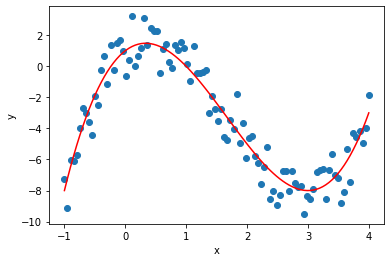

In [61]:
m = 100
x = np.linspace(-1, 4, m) #endpoint <= !
y_orig = x**3 - 5*x**2 + 3*x + 1
y_with_noise = x**3 - 5*x**2 + 3*x + 1 + np.random.normal(0,1,m)
fig, ax = plt.subplots()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.plot(x, y_orig, c = 'r', label="original function")
ax.scatter(x, y_with_noise)

Text(0, 0.5, 'y')

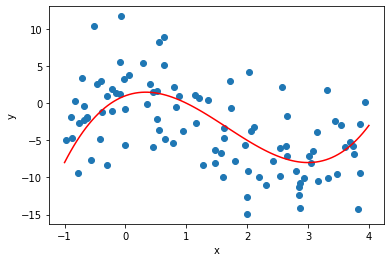

### Ordinary linear regression
Consider an extended set of features: $\mathbf{x}=(x,x^2,\dots,x^d)$ (`PolynomialFeatures`) and the correspondent linear regression problem:
$$ L_S(h)=\frac{1}{m}\sum_{i=1}^m(\langle\mathbf{w},\mathbf{x}_i\rangle+b-y_i)^2\to\min_{\mathbf{w},b}$$
The hypothesis class
$$\mathcal H_d=\{\mathbf{x}\mapsto h(\mathbf{x})=\langle\mathbf{w},\mathbf{x}\rangle+b\},$$
depends on the hyperparameter $d$. Consider the training errors
$$ \psi(d)=\inf_{\mathbf{w},b} L_S(h)$$
and average cross-validation errors 
$$ \overline\psi(d)=\frac{1}{k}\sum_{i=1}^k\psi_i(d),\quad \psi_i(d)=\inf_{\mathbf{w},b} L_{S\backslash S_i}(h)$$
for different values of $d$. Here $(S_1,\dots,S_d)$ is a partition of $S$, considered in the cross-validation. 

**2. Find $d$ with the best average cross-validation score.** 

best average cross-validation score: d= 3


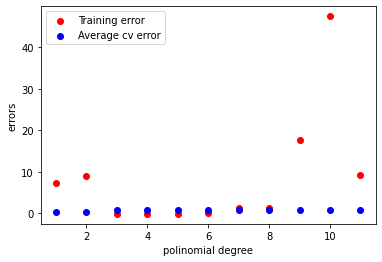

In [130]:
d = np.arange(1,12)
#print(d)
errors = []
train_errors = []
for i in d:
    x = np.linspace(-1, 4, m).reshape(len(x),1) #нужно пересоздавать, иначе он почему-то использует старые значения
    polynom = PolynomialFeatures(i, include_bias=False)
    lin_regr = LinearRegression()
    scores_cvs = cross_val_score(lin_regr,polynom.fit_transform(x),y_with_noise,cv=10)
    errors.append(-np.mean(scores_cvs))  #средняя ошибка
    train = lin_regr.fit(polynom.fit_transform(x),y_with_noise) #обучение
    score_tr = train.score(polynom.fit_transform(x),y_with_noise) 
    train_errors.append(score_tr)
fig, ax = plt.subplots()
ax.set_xlabel('polinomial degree')
ax.set_ylabel('errors')
ax.scatter(d, errors, c='r')
ax.scatter(d, train_errors, c='b')
ax.legend(['Training error','Average cv error'])
print("best average cross-validation score: d=", np.argmin(errors) + 1)

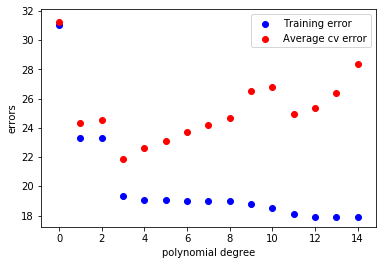

**3. (a) Compute the training error of this predictor for the RMSE (root mean square error) evaluation metrics. Compare with the standard deviation of the data. (b) By the means of scatter plots compare the coefficients of the best predictor and the original coefficients.** 

1.0257442171614424


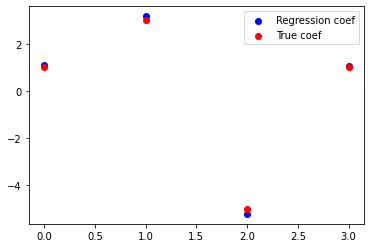

In [131]:
#__________a_____________
polynom = PolynomialFeatures(3, include_bias = False).fit_transform(x)
lin_regr = LinearRegression().fit(polynom, y_with_noise)
RMSE = mean_squared_error(lin_regr.predict(polynom), y_with_noise, squared=False)
print(RMSE)
#__________b_____________
coef_bp = []
coef_bp.extend([lin_regr.intercept_])
coef_bp.extend(lin_regr.coef_)
fig, ax = plt.subplots()
ax.scatter(np.arange(4), coef_bp, c='b')
ax.scatter(np.arange(4), [1,3,-5,1], c='r')
ax.legend(['Regression coef','True coef'])

Best degree: 3
RMSE for the regression predictor with the best d: 4.394499627044507


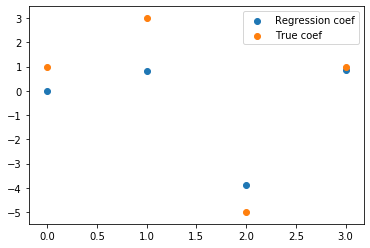

**4. Show the graphs of the predictors for d=3 and d=10 along with the unperturbed original function.**

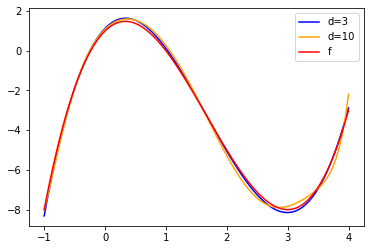

In [132]:
polynom = PolynomialFeatures(10, include_bias = False)
lin_regr = LinearRegression().fit(polynom.fit_transform(x), y_with_noise)
coef_d10 = []
coef_d10.extend([lin_regr.intercept_])
coef_d10.extend(lin_regr.coef_) 
y_d10 = np.polynomial.Polynomial(coef_d10)
y_bp = np.polynomial.Polynomial(coef_bp)
fig, ax = plt.subplots()
ax.plot(x,y_bp(x), c ='b')
ax.plot(x,y_d10(x), c ='orange')
ax.plot(x,y_orig, c ='r')
ax.legend(['d=3','d=10','f']) 

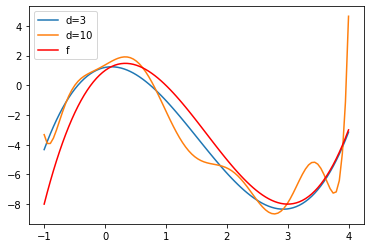

### Ridge regression
Objective function in scikit-learn:
$$ m\cdot L_S(h)+\alpha\|w\|_2^2$$
**5. (a) Take a class polynomials, having a fixed large degree ($d=10$) and select the best regularization parameter $\alpha$. Compute the training error for the RMSE evaluation metrics for the best 
$\alpha$.**  

Consider log-scale for $\alpha$:
`alphas=np.logspace(a_1,a_2,N=50,endpoint=True,b=10.0)`: 
$$ z_i=a_1+\frac{a_2-a_1}{N-1}i,\quad i=0,\dots,N-1,$$
$$ \alpha_i=b^{z_i},\quad i=0,\dots,N-1.$$
Note that the difference
$$ \log_b \alpha_{i+1}-\log_b(\alpha_i)=z_{i+1}-z_i=\frac{a_2-a_1}{N-1}$$
is constant.

**5. (b) Show the dependence of the training and cross-validation errors on the regularization parameter**

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best regularization parameter:  6.1054022965853285
RMSE for the best Ridge regression predictor:  1.1545156728504262


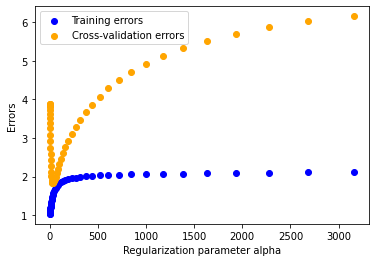

In [133]:
#________с подбором коэфициентов_________________
alphas=np.logspace(0,3.5,50,endpoint=True) #что за параметр вообще b=10.0???
reg_ridge = Ridge()
grid = GridSearchCV(estimator=reg_ridge, param_grid= {'alpha' : alphas} , scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1) #поиск лучших параметров для обучения модели
grid_fit = grid.fit(polynom.fit_transform(x) , y_with_noise) #обучение с этими параметрами для d=10
#________________________________________________
polynom = PolynomialFeatures(10, include_bias = False)
train_errors = []
crv_errors = []
for i in alphas:
    reg_ridge = Ridge(alpha=i)
    reg_ridge.fit(polynom.fit_transform(x), y_with_noise)
    train_errors.append(mean_squared_error(reg_ridge.predict(polynom.fit_transform(x)), y_with_noise, squared=False))
    scores = cross_val_score(reg_ridge, polynom.fit_transform(x), y_with_noise, cv=10 , scoring = 'neg_root_mean_squared_error')
    crv_errors.append(-np.mean(scores))
fig, ax = plt.subplots()
ax.set_ylabel('Errors')
ax.set_xlabel('Regularization parameter alpha')
ax.scatter(alphas,train_errors, c ='b')
ax.scatter(alphas,crv_errors, c ='orange')
ax.legend(['Training errors','Cross-validation errors'])
print("Best regularization parameter: ", grid_fit.best_estimator_.alpha)
print("RMSE for the best Ridge regression predictor: ", mean_squared_error(grid_fit.predict(polynom.fit_transform(x)), y_with_noise, squared=False))


Best regularization parameter: 380.41453801905874
RMSE for the best Ridge regression predictor: 4.5302694295663395


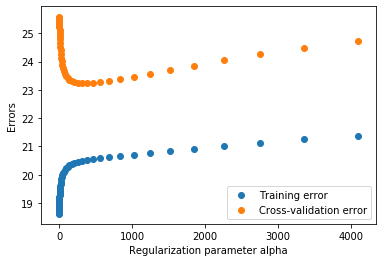

**6. Show the graphs of the best Ridge predictor along with the graph of the unperturbed original function.**

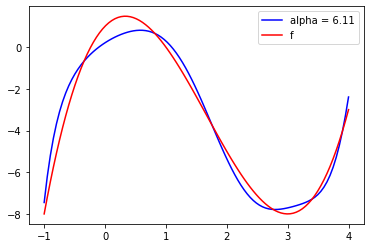

In [120]:
a = grid_fit.best_estimator_.alpha #besr Ridge predictor
reg_ridg = Ridge(alpha=a)
reg_ridg.fit(polynom.fit_transform(x), y_with_noise)
predict_alpha = reg_ridg.predict(polynom.fit_transform(x))

fig, ax = plt.subplots()
ax.plot(x, predict_alpha, c = 'b')
ax.plot(x, y_orig, c ='r')
ax.legend(['alpha = ' + str(round (a, 2)),'f'])

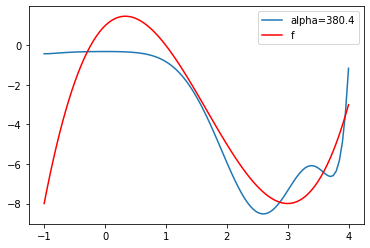

### Lasso regression
Objective function in scikit-learn:
$$ \frac{1}{2}L_S(h)+\alpha\|w\|_1.$$
**7. The problem is the same as 5, 6 for Ridge regression.**

Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.367e+02, tolerance: 1.294e-01
  model = cd_fast.enet_coordinate_descent(
C:\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.671e+02, tolerance: 1.294e-01
  model = cd_fast.enet_coordinate_descent(
C:\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.137e+02, tolerance: 1.222e-01
  model = cd_fast.enet_coo

Best regularization parameter:  2.6826957952797255
RMSE for the best Ridge regression predictor:  2.2196214177863234


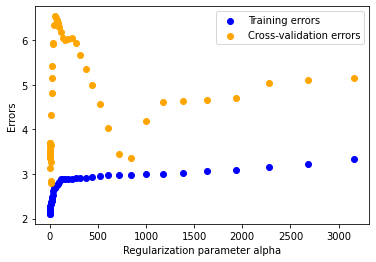

In [136]:
#________с подбором коэфициентов_________________
alphas=np.logspace(0,3.5,50,endpoint=True) #что за параметр вообще b=10.0???
polynom = PolynomialFeatures(10, include_bias = False)
reg_lasso = Lasso(max_iter=10000)
grid = GridSearchCV(estimator=reg_lasso, param_grid= {'alpha' : alphas} , scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1) #поиск лучших параметров для обучения модели
grid_fit = grid.fit(polynom.fit_transform(x) , y_with_noise) #обучение с этими параметрами для d=10
#________________________________________________
polynom = PolynomialFeatures(10, include_bias = False)
train_errors = []
crv_errors = []
for i in alphas:
    reg_lasso = Lasso(alpha=i, max_iter=10000)
    reg_lasso.fit(polynom.fit_transform(x), y_with_noise)
    train_errors.append(mean_squared_error(reg_lasso.predict(polynom.fit_transform(x)), y_with_noise, squared=False))
    scores = cross_val_score(reg_lasso, polynom.fit_transform(x), y_with_noise, cv=10 , scoring = 'neg_root_mean_squared_error')
    crv_errors.append(-np.mean(scores))
fig, ax = plt.subplots()
ax.set_ylabel('Errors')
ax.set_xlabel('Regularization parameter alpha')
ax.scatter(alphas,train_errors, c = 'b')
ax.scatter(alphas,crv_errors, c = 'orange')
ax.legend(['Training errors','Cross-validation errors'])
print("Best regularization parameter: ", grid_fit.best_estimator_.alpha)
print("RMSE for the best Ridge regression predictor: ", mean_squared_error(grid_fit.predict(polynom.fit_transform(x)), y_with_noise, squared=False))

C:\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.367e+02, tolerance: 1.294e-01
  model = cd_fast.enet_coordinate_descent(


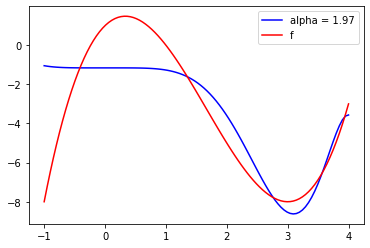

In [138]:
alpha = grid_fit.best_estimator_.alpha #besr Ridge predictor
reg_lasso = Lasso(alpha=alpha, max_iter=10000)
reg_lasso.fit(polynom.fit_transform(x), y_with_noise)
predict_alpha = reg_lasso.predict(polynom.fit_transform(x))

fig, ax = plt.subplots()
ax.plot(x,predict_alpha, c ='b')
ax.plot(x,y_orig, c = 'r')
ax.legend(['alpha = ' + str(round (a, 2)),'f'])

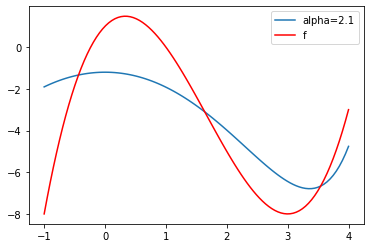

## Elastic net
Objective function in scikit-learn: 
$$ \frac{1}{2}L_S(h)+\alpha r \|\mathbf w\|_1+\frac{1}{2}\alpha(1-r)\|\mathbf{w}\|_2^2.$$
**8. Fix some large $d$ and use `GridSearchCV` to find the best combination of $\alpha$ and $r$ (`l1_ratio`).**

In [139]:
alpha = np.logspace(0,3.5,50,endpoint=True)
l1_ratio = np.linspace(0,1,11)
reg_elnet = ElasticNet()
grid = GridSearchCV(estimator=reg_elnet, param_grid={'alpha' : alpha, 'l1_ratio' : l1_ratio }, scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1)
grid_fit = grid.fit(polynom.fit_transform(x), y_with_noise)
print("Best Estimator: ", grid_fit.best_estimator_)
print("RMSE for the best parameters: ", mean_squared_error(grid_fit.predict(polynom.fit_transform(x)), y_with_noise, squared=False))

Fitting 5 folds for each of 550 candidates, totalling 2750 fits
Best Estimator:  ElasticNet(alpha=1.93069772888325, l1_ratio=0.2)
RMSE for the best parameters:  2.0907139812394555


C:\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.448e+02, tolerance: 1.294e-01
  model = cd_fast.enet_coordinate_descent(


best parameters: {'alpha': 2.519842099789746, 'l1_ratio': 0.7777777777777777, 'tol': 0.5}
Best Estimator: ElasticNet(alpha=2.519842099789746, copy_X=True, fit_intercept=True,
           l1_ratio=0.7777777777777777, max_iter=1000, normalize=False,
           positive=False, precompute=False, random_state=None,
           selection='cyclic', tol=0.5, warm_start=False)
RMSE for the best papameters: 4.870019852147862


**9. Show the graphs of the best predictor along with the graph of the unperturbed original function.**

C:\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.448e+02, tolerance: 1.294e-01
  model = cd_fast.enet_coordinate_descent(


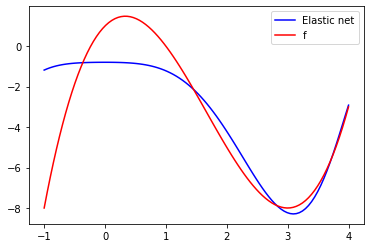

In [140]:
reg_elnet = ElasticNet(alpha=grid_fit.best_estimator_.alpha, l1_ratio=grid_fit.best_estimator_.l1_ratio)
reg_elnet_fit = reg_elnet.fit(polynom.fit_transform(x), y_with_noise)
predict_elastic = reg_elnet_fit.predict(polynom.fit_transform(x))
fig, ax = plt.subplots()
ax.plot(x,predict_elastic, c = 'b')
ax.plot(x,y_orig, c = 'r')
ax.legend(['Elastic net','f'])

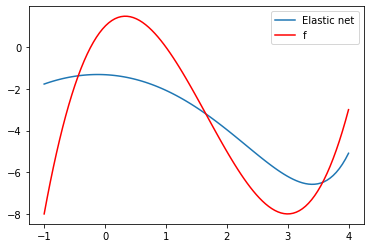

**10. Show the coefficients of the best Lasso and ElasticNet predictors**

[-1.1595104547715471, 0.0, -0.0, -0.0, -0.0, -0.12072952364363775, -0.0, 0.010455289180238856, 0.0008749286179949534, -0.00012274026501181613, -7.17572077287794e-05]
[-0.7958682555502805, 0.0, -0.1327809740347247, -0.06367829287667592, -0.28057591640386037, 0.04461135691053215, 0.009341356483406782, 0.000969508735172445, -1.72090986934038e-05, -3.564367050732463e-05, -1.282730991297186e-05]


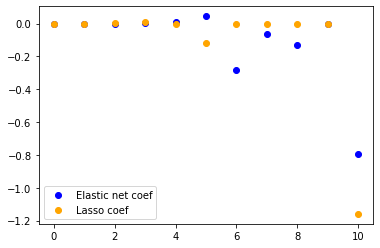

In [152]:
coef_lasso = []
coef_lasso.extend([reg_lasso.intercept_])
coef_lasso.extend(reg_lasso.coef_)
print(coef_lasso)
coef_elnet = []
coef_elnet.extend([reg_elnet.intercept_])
coef_elnet.extend(reg_elnet.coef_)
print(coef_elnet)
fig, ax = plt.subplots()
ax.scatter(np.arange(11),coef_elnet[::-1], c='b')
ax.scatter(np.arange(11),coef_lasso[::-1], c='orange')
ax.legend(['Elastic net coef','Lasso coef'])